In [35]:
import asyncio
import websockets
import json
import pandas as pd
import datetime as dt
import nest_asyncio
from concurrent.futures import ThreadPoolExecutor
nest_asyncio.apply()
from scipy import stats
import os

import datetime
from pandas.io.json import json_normalize
import numpy as np
from scipy import interpolate
import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import skewnorm
import matplotlib.pyplot as plt

from market_data import HistData
from market_data import Options

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
posn_path = os.path.join(os.getcwd(), "performance_analytics","positions.xlsx")
idx_path = os.path.join(os.getcwd(), "performance_analytics","eth_index.csv")

In [37]:
hdata = HistData('ETH')
start_dt = int(pd.to_datetime('20240101').timestamp()*1000)
end_dt = int(pd.datetime.today().timestamp()*1000)
eth_idx = hdata.get_hist_data(start_dt,end_dt,'ETH-PERPETUAL','1D')[['close']]
eth_idx.index = [dt.strftime('%Y-%m-%d') for dt in eth_idx.index]
eth_idx.index.names = ['Date']
eth_idx.to_csv(idx_path)

In [38]:
positions = pd.read_excel(posn_path,index_col = 0)
idx_px = pd.read_csv(idx_path,index_col = 0)

In [39]:
idx_px.index,positions.index = pd.to_datetime(idx_px.index),pd.to_datetime(positions.index,infer_datetime_format=True)


In [40]:
#idx_px.index = [dt.strftime('%Y/%d/%') for dt in pd.to_datetime(idx_px.index)]
#positions.index = [dt.strftime('%Y-%d-%d') for dt in pd.to_datetime(positions.index)]

idx_px.index.names,positions.index.names = ['Date'],['Date']

In [41]:
usd_rets = positions.join(idx_px,on='Date',how = 'left')

In [42]:

usd_rets['Tactical Beta Convexity'] = usd_rets['close'].diff()*usd_rets['positions']

In [43]:
vol_float_pnl_path = "c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\Volatility\\ShortVolatility\\performance_analytics\\floating_rets.csv"
vol_rel_pnl_path = "c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\Volatility\\ShortVolatility\\performance_analytics\\realized_rets.csv"

In [44]:
vol_float_rets = pd.read_csv(vol_float_pnl_path,index_col = 0)
vol_rel_rets = pd.read_csv(vol_rel_pnl_path,index_col = 0)
vol_rel_rets = vol_rel_rets.groupby(vol_rel_rets.index).sum()

In [45]:

vol_float_rets.index = [dt.strftime('%Y-%m-%d') for dt in pd.to_datetime(vol_float_rets.index,format="%d/%m/%Y")]
vol_rel_rets.index = [dt.strftime('%Y-%m-%d') for dt in pd.to_datetime(vol_rel_rets.index)]

In [46]:
vol_rets = pd.DataFrame(pd.concat([vol_float_rets,vol_rel_rets],axis=1).sum(axis=1),columns = ['Short Volatility'])

In [47]:
curr_px = usd_rets['close'].iloc[-1]
vol_rets = vol_rets*curr_px

In [48]:
convexity = usd_rets[['Tactical Beta Convexity']]
convexity.index = [dt.strftime('%Y-%m-%d') for dt in pd.to_datetime(convexity.index)]

In [49]:
usd_rets = pd.concat([convexity,vol_rets],axis=1)
usd_rets['Total'] = usd_rets['Tactical Beta Convexity']+usd_rets['Short Volatility']

In [50]:
usd_rets=usd_rets/2250

In [55]:
usd_rets.index = pd.to_datetime(usd_rets.index)

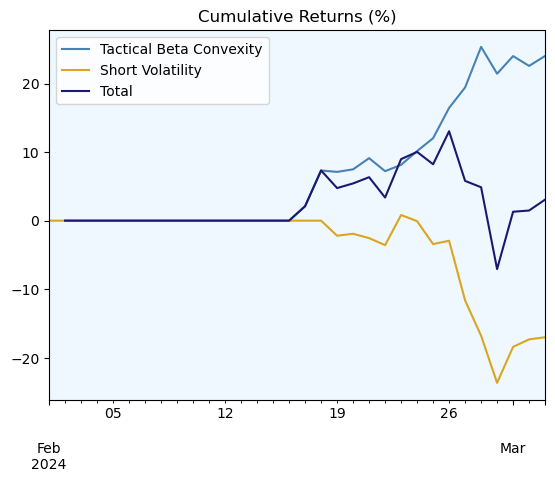

In [56]:
plot = (((1+(usd_rets)).cumprod()-1)*100).plot(title = 'Cumulative Returns (%)',color = ['steelblue','goldenrod','midnightblue'])
plot.set_facecolor('aliceblue')
picpath = "c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\'MasterFundPerformance.png"
plot.get_figure().savefig(picpath)